In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy.special import inv_boxcox
from scipy.stats import boxcox

tf.config.run_functions_eagerly(True)

In [ ]:
# Read in buoy data
buoy=pd.read_csv('data/buoy41002.csv')
buoy['time']=pd.to_datetime(buoy['time'])

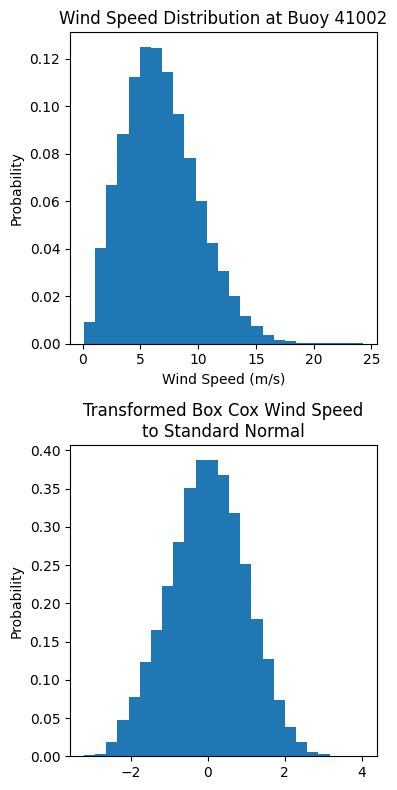

In [ ]:
# Plot distributions of buoy data

# Histogram of buoy data
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(4,8))
axs[0].set_title('Wind Speed Distribution at Buoy 41002')
axs[0].hist(buoy['w'], bins=25, density=True)
axs[0].set_xlabel('Wind Speed (m/s)')
axs[0].set_ylabel('Probability')

# Histogram of buoy data after transformed to standard normal distribution
xt, lmbda = boxcox(buoy['w'])
mn,std=xt.mean(),xt.std()
xt=(xt-mn)/std
axs[1].hist(xt,bins=25,density=True)
axs[1].set_title('Transformed Box Cox Wind Speed\nto Standard Normal')
axs[1].set_ylabel('Probability')


plt.tight_layout()

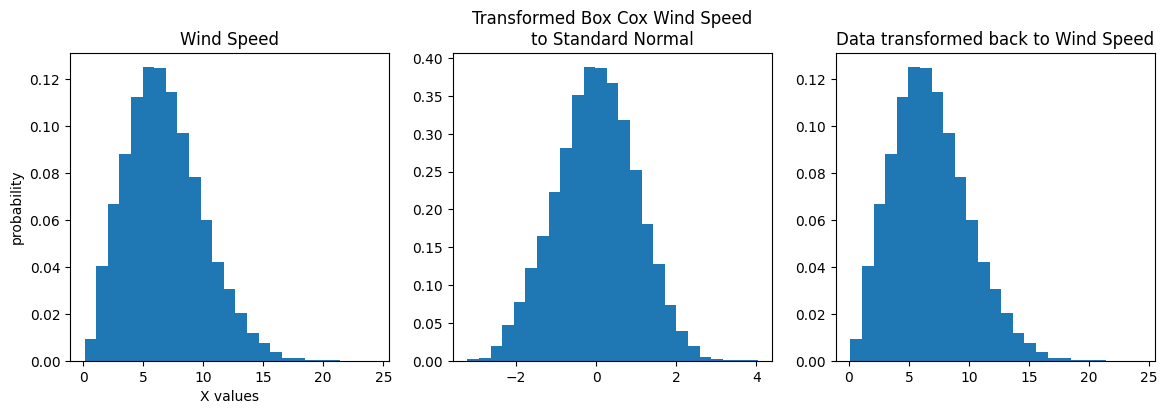

In [ ]:
# Plot distributions of buoy data

# Histogram of buoy data
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(14, 4))
axs[0].set_title('Wind Speed')
axs[0].hist(buoy['w'], bins=25, density=True)
axs[0].set_xlabel('X values')
axs[0].set_ylabel('probability')

# Histogram of buoy data after transformed to standard normal distribution
xt, lmbda = boxcox(buoy['w'])
mn,std=xt.mean(),xt.std()
xt=(xt-mn)/std
axs[1].hist(xt,bins=25,density=True)
axs[1].set_title('Transformed Box Cox Wind Speed\nto Standard Normal')

# Histogram of standard normal distribution transformed back to wind speed
xt=xt*std+mn
xt_t=inv_boxcox(xt,lmbda)
axs[2].hist(xt_t,bins=25,density=True)
axs[2].set_title('Data transformed back to Wind Speed')
plt.show()

In [ ]:
# Read in NBS
nbs=xr.open_dataset('data/nbs_train.nc')

# Window size is 2n+1
n=10

center=[360-75,31.75]
lats=np.arange(center[1]-n*.25,center[1]+(n+1)*.25,.25)
lons=np.arange(center[0]-n*.25,center[0]+(n+1)*.25,.25)
# Get locations within image
lat_bounds=[min(lats),max(lats)]
lon_bounds=[min(lons),max(lons)]

# Select only data near buoy
nbs=nbs.sel(lat=slice(min(lats),max(lats)),lon=slice(min(lons),max(lons)))

In [ ]:
# Split the buoy data into train/val/test
Y_train=buoy.loc[buoy['fold']<=3]
Y_val=buoy.loc[buoy['fold']==4]
Y_test=buoy.loc[buoy['fold']==5]
Y_train

# Get the times for each dataset
train_times=Y_train['time']
val_times=Y_val['time']
test_times=Y_test['time']

# Split NBS into train/val/test
X_train=nbs.sel(time=nbs['time'].isin(Y_train['time']))
X_val=nbs.sel(time=nbs['time'].isin(Y_val['time']))
X_test=nbs.sel(time=nbs['time'].isin(Y_test['time']))

In [ ]:
Y_train=np.array(Y_train['w'])
Y_val=np.array(Y_val['w'])
Y_test=np.array(Y_test['w'])

X_train=np.array(X_train['w'])
X_val=np.array(X_val['w'])
X_test=np.array(X_test['w'])

In [ ]:
Y_test.min(),Y_test.max(),Y_train.min(),Y_train.max()

(0.5567567567567568, 19.41081081081081, 0.2, 24.27916666666667)

In [ ]:
X_test.max(),X_train.max(),X_val.max()

(49.72066, 50.558, 70.0)

In [ ]:
# Standardize the buoy data

# First apply box cox to train data to get normal distribution
Y_train, lmbda_y = boxcox(Y_train)
# Get mean and stdev and convert to standard normal
mean_y,std_y=Y_train.mean(),Y_train.std()
Y_train=(Y_train-mean_y)/std_y

# Use boxcox with known lambda on other variables
Y_val = scipy.special.boxcox(Y_val, lmbda_y)
Y_val = (Y_val-mean_y)/std_y
Y_test = scipy.special.boxcox(Y_test,lmbda_y)
Y_test = (Y_test-mean_y)/std_y

# To convert back later
# xt=xt*std+mn
# xt_t=inv_boxcox(xt,lmbda)

In [ ]:
#X_train2[X_train2==0]=0.001
#X_train2=X_train.flatten()
#X_train2, lmbda_x = boxcox(X_train2)
#X_train2=X_train2.reshape(19016,1,21,21)
#X_train2

In [ ]:
# Standardize NBS data

x_train_shape=X_train.shape
x_val_shape=X_val.shape
x_test_shape=X_test.shape

# Make all values positive and flatten to 1D
X_train[X_train==0]=0.001
X_train=X_train.flatten()
# Apply box cox to train data to get normal distribution
X_train, lmbda_x = boxcox(X_train)
X_train=X_train.reshape(x_train_shape)

#X_train, lmbda_x = boxcox(X_train)
# Get mean and stdev and convert to standard normal
#X_train=np.log(X_train)
mean_x,std_x=X_train.mean(),X_train.std()
X_train=(X_train-mean_x)/std_x

# Use boxcox with known lambda on other variables
X_val[X_val==0]=0.001
X_val = scipy.special.boxcox(X_val, lmbda_x)
X_val = (X_val-mean_x)/std_x
X_test[X_test==0]=0.001
X_test = scipy.special.boxcox(X_test,lmbda_x)
X_test = (X_test-mean_x)/std_x

# To convert back later
# xt=xt*std+mn
# xt_t=inv_boxcox(xt,lmbda)

In [ ]:
Y_train.min(),Y_train.max(),Y_val.max(),Y_test.max()

(-3.1298556098958907, 3.924027363120628, 3.3478156764135596, 3.036666641320443)

In [ ]:
X_train.min(),X_train.max(),X_val.max(),X_test.max()

(-4.366585, 8.468104, 11.025404, 8.34894)

In [ ]:
# Remove the zlev dimension
X_train=X_train.squeeze()
X_val=X_val.squeeze()
X_test=X_test.squeeze()

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), input_shape=(21, 21, 1)))
model.add(layers.LeakyReLU(alpha=0.9))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3),))
model.add(layers.LeakyReLU(alpha=0.9))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(10))
model.add(layers.LeakyReLU(alpha=0.9))
model.add(layers.Dense(1,activation='linear'))

In [ ]:
#model.summary()

In [ ]:
from tensorflow.python.ops import math_ops
import keras

sigma=np.sqrt(2)/2
def custom_loss(y_true,y_pred):
  diff=-math_ops.squared_difference(y_pred, y_true)/(2*sigma**2)
  es=math_ops.exp(diff)
  diff = 1 - es
  result=tf.math.reduce_sum(diff)
  return result

In [ ]:
model.compile(loss = custom_loss, metrics='mse',
              optimizer=keras.optimizers.Adam(learning_rate = 1e-5))

In [ ]:
epochs=3
batch_size=256

In [ ]:
history=model.fit(X_train,Y_train,epochs=epochs,
                  batch_size=batch_size, validation_data=(X_val,Y_val))

Epoch 1/3
 1/75 [..............................] - ETA: 5s - loss: 114.2694 - mse: 1.0614

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


75/75 [==============================] - 3s 46ms/step - loss: 98.5966 - mse: 0.8114 - val_loss: 64.7591 - val_mse: 0.4445
Epoch 2/3
75/75 [==============================] - 3s 44ms/step - loss: 77.8329 - mse: 0.5650 - val_loss: 56.9544 - val_mse: 0.3875
Epoch 3/3
75/75 [==============================] - 4s 54ms/step - loss: 70.4711 - mse: 0.5070 - val_loss: 57.2657 - val_mse: 0.3944


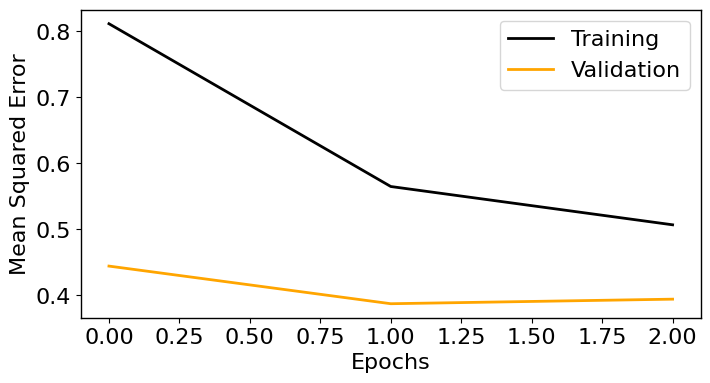

In [ ]:
# Plot training graph

fig = plt.figure(figsize=(8, 4))
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 1
plt.plot(history.history['mse'], label='Training', color='black', linewidth=2)
plt.plot(history.history['val_mse'], label = 'Validation', color='orange', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()

In [ ]:
X_test.max()

8.34894

In [ ]:
pred = model.predict(X_test)

52/52 [==============================] - 0s 7ms/step


(array([  3.,   5.,   7.,  18.,  29.,  37.,  93., 107., 129., 148., 183.,
        184., 170., 164., 135.,  87.,  57.,  32.,  20.,  19.,   4.,   2.,
          0.,   1.,   1.]),
 array([-2.20020604, -1.99889696, -1.79758787, -1.59627879, -1.3949697 ,
        -1.19366062, -0.99235153, -0.79104239, -0.5897333 , -0.38842425,
        -0.18711515,  0.01419394,  0.21550304,  0.41681212,  0.61812121,
         0.81943029,  1.02073944,  1.22204852,  1.42335761,  1.62466669,
         1.82597578,  2.02728486,  2.22859383,  2.42990303,  2.631212  ,
         2.8325212 ]),
 <BarContainer object of 25 artists>)

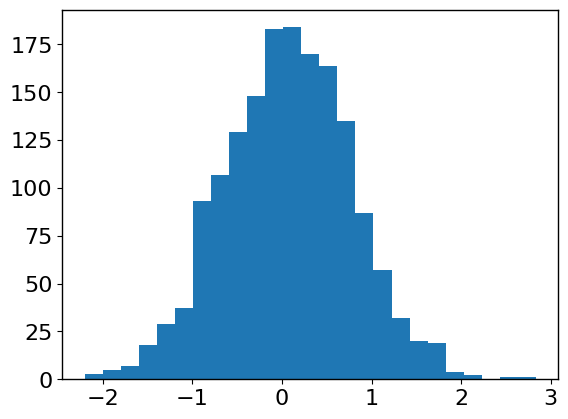

In [ ]:
plt.hist(pred,bins=25)

(array([  5.,   7.,  11.,  25.,  34.,  42.,  71.,  77.,  98., 149., 165.,
        183., 134., 131., 129., 119.,  87.,  57.,  50.,  29.,  15.,   8.,
          3.,   3.,   3.]),
 array([-2.72713034, -2.49657846, -2.26602658, -2.0354747 , -1.80492282,
        -1.57437094, -1.34381906, -1.11326718, -0.8827153 , -0.65216343,
        -0.42161155, -0.19105967,  0.03949221,  0.27004409,  0.50059597,
         0.73114785,  0.96169973,  1.19225161,  1.42280349,  1.65335537,
         1.88390725,  2.11445912,  2.345011  ,  2.57556288,  2.80611476,
         3.03666664]),
 <BarContainer object of 25 artists>)

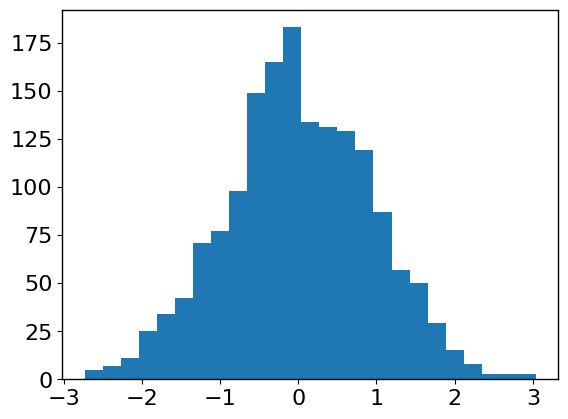

In [ ]:
plt.hist(Y_test,bins=25)

In [ ]:
pd.DataFrame(pred).describe()

,0
count,1635.000000
mean,0.071175
std,0.709247
min,-2.200206
25%,-0.416090
50%,0.087608
75%,0.559235
max,2.832521


In [ ]:
#pred=pred/
pred=pred*std_y+mean_y
pred=inv_boxcox(pred,lmbda_y)
true=Y_test*std_y+mean_y
true=inv_boxcox(true,lmbda_y)

In [ ]:
pred=pred.squeeze()

In [ ]:
diffs=pred-true
pd.DataFrame(diffs).describe()

,0
count,1635.000000
mean,0.081004
std,1.888821
min,-8.046492
25%,-0.937259
50%,0.132407
75%,1.122141
max,8.255464


In [ ]:
diffs=abs(pred-true)
pd.DataFrame(diffs).describe()

,0
count,1635.000000
mean,1.402451
std,1.267336
min,0.001111
25%,0.500036
50%,1.044395
75%,1.970206
max,8.255464


In [ ]:
(np.mean((pred-true)**2))**0.5

1.889980483810055

In [ ]:
results=pd.DataFrame({'time':test_times,'pred':pred,'true':true})
results

,time,pred,true
23757,2017-01-16 00:00:00,4.828883,4.300000
23758,2017-01-16 06:00:00,4.522995,3.745714
23759,2017-01-16 12:00:00,4.196389,1.562162
23760,2017-01-16 18:00:00,4.939205,3.080000
23761,2017-01-17 00:00:00,4.619468,3.994595
...,...,...,...
25387,2018-02-28 06:00:00,7.579211,7.011429
25388,2018-02-28 12:00:00,6.885660,6.145946
25389,2018-02-28 18:00:00,7.550570,5.382857
25390,2018-03-01 00:00:00,7.126652,5.162162


Text(0.5, 1.0, 'CNN Output for Test Data')

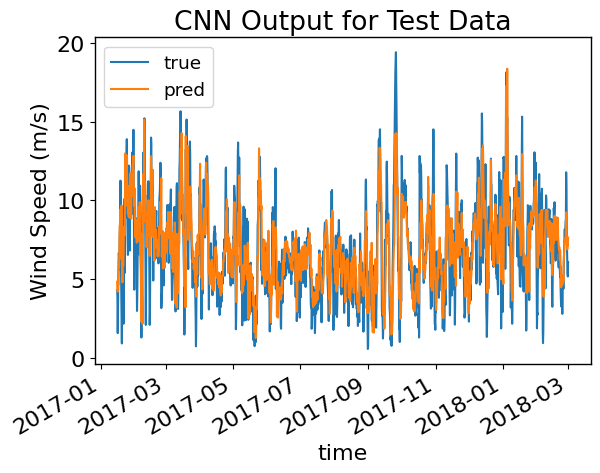

In [ ]:
results.plot(x='time',y=['true','pred'])
plt.legend(fontsize='small')
plt.ylabel('Wind Speed (m/s)')
plt.title('CNN Output for Test Data')

In [ ]:
from joblib import dump
dump(model,'CNN_standardizedboxcox_customloss_leakyrelu.joblib')
results.to_csv('CNN_standardizedboxcox_testresults_customloss_leakyrelu.csv')